In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mathumithram_rice_pest_detection_path = kagglehub.dataset_download('mathumithram/rice-pest-detection')

print('Data source import complete.')

100%|██████████| 356M/356M [00:03<00:00, 101MB/s]

Extracting files...


Data source import complete.


# Import Library

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
import numpy as np

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramaadjiprasetyo","key":"0abc391eac207d40715234a6e3b49556"}'}

In [ ]:
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

# Load dataset

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mathumithram/rice-pest-detection")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [ ]:
!kaggle datasets download -d mathumithram/rice-pest-detection
!unzip rice-pest-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessedDataset/3/3 (342).jpg  
  inflating: preprocessedDataset/3/3 (343).jpg  
  inflating: preprocessedDataset/3/3 (344).jpg  
  inflating: preprocessedDataset/3/3 (345).jpg  
  inflating: preprocessedDataset/3/3 (346).jpg  
  inflating: preprocessedDataset/3/3 (347).jpg  
  inflating: preprocessedDataset/3/3 (348).jpg  
  inflating: preprocessedDataset/3/3 (349).jpg  
  inflating: preprocessedDataset/3/3 (35).jpg  
  inflating: preprocessedDataset/3/3 (350).jpg  
  inflating: preprocessedDataset/3/3 (351).jpg  
  inflating: preprocessedDataset/3/3 (352).jpg  
  inflating: preprocessedDataset/3/3 (353).jpg  
  inflating: preprocessedDataset/3/3 (354).jpg  
  inflating: preprocessedDataset/3/3 (355).jpg  
  inflating: preprocessedDataset/3/3 (356).jpg  
  inflating: preprocessedDataset/3/3 (357).jpg  
  inflating: preprocessedDataset/3/3 (358).jpg  
  inflating: preprocessedDataset/3/3 (359).jpg  
  inflating: prepro

## Rename tiap folder menjadi kelas untuk tiap hama

In [ ]:
pest_name_mapping = {
    "0": "rice_leaf_roller",
    "1": "rice_leaf_caterpillar",
    "2": "paddy_stem_maggot",
    "3": "asiatic_rice_borer",
    "4": "yellow_rice_borer",
    "5": "rice_gall_midge",
    "6": "brown_plant_hopper",
    "7": "rice_stem_fly",
    "8": "rice_water_weevil",
    "9": "rice_leaf_hopper",
    "10": "rice_shell_pest",
    "11": "thrips"
}

In [ ]:
base_path = '/content/preprocessedDataset'
copy_path = 'rice-pest-detection/raw_dataset'

os.makedirs(copy_path, exist_ok=True)

# Salin semua folder ke lokasi kerja
for folder in os.listdir(base_path):
    src = os.path.join(base_path, folder)
    dst = os.path.join(copy_path, folder)
    if os.path.isdir(src):
        shutil.copytree(src, dst)
        print(f"Copied {folder}")

Copied 1
Copied 10
Copied 3
Copied 9
Copied 11
Copied 2
Copied 4
Copied 8
Copied 0
Copied 5
Copied 6
Copied 7


In [ ]:
# Lakukan rename setelah berhasil copy
renamed_path = 'rice-pest-detection/dataset'
os.makedirs(renamed_path, exist_ok=True)

for folder in os.listdir(copy_path):
    if folder in pest_name_mapping:
        old_path = os.path.join(copy_path, folder)
        new_folder_name = pest_name_mapping[folder]
        new_path = os.path.join(renamed_path, new_folder_name)

        if os.path.exists(new_path):
            print(f"[SKIP] Target already exists: {new_path}")
            continue

        shutil.move(old_path, new_path)
        print(f"Renamed {folder} → {new_folder_name}")

Renamed 1 → rice_leaf_caterpillar
Renamed 10 → rice_shell_pest
Renamed 3 → asiatic_rice_borer
Renamed 9 → rice_leaf_hopper
Renamed 11 → thrips
Renamed 2 → paddy_stem_maggot
Renamed 4 → yellow_rice_borer
Renamed 8 → rice_water_weevil
Renamed 0 → rice_leaf_roller
Renamed 5 → rice_gall_midge
Renamed 6 → brown_plant_hopper
Renamed 7 → rice_stem_fly


## Plot gambar sampel untuk semua kelas

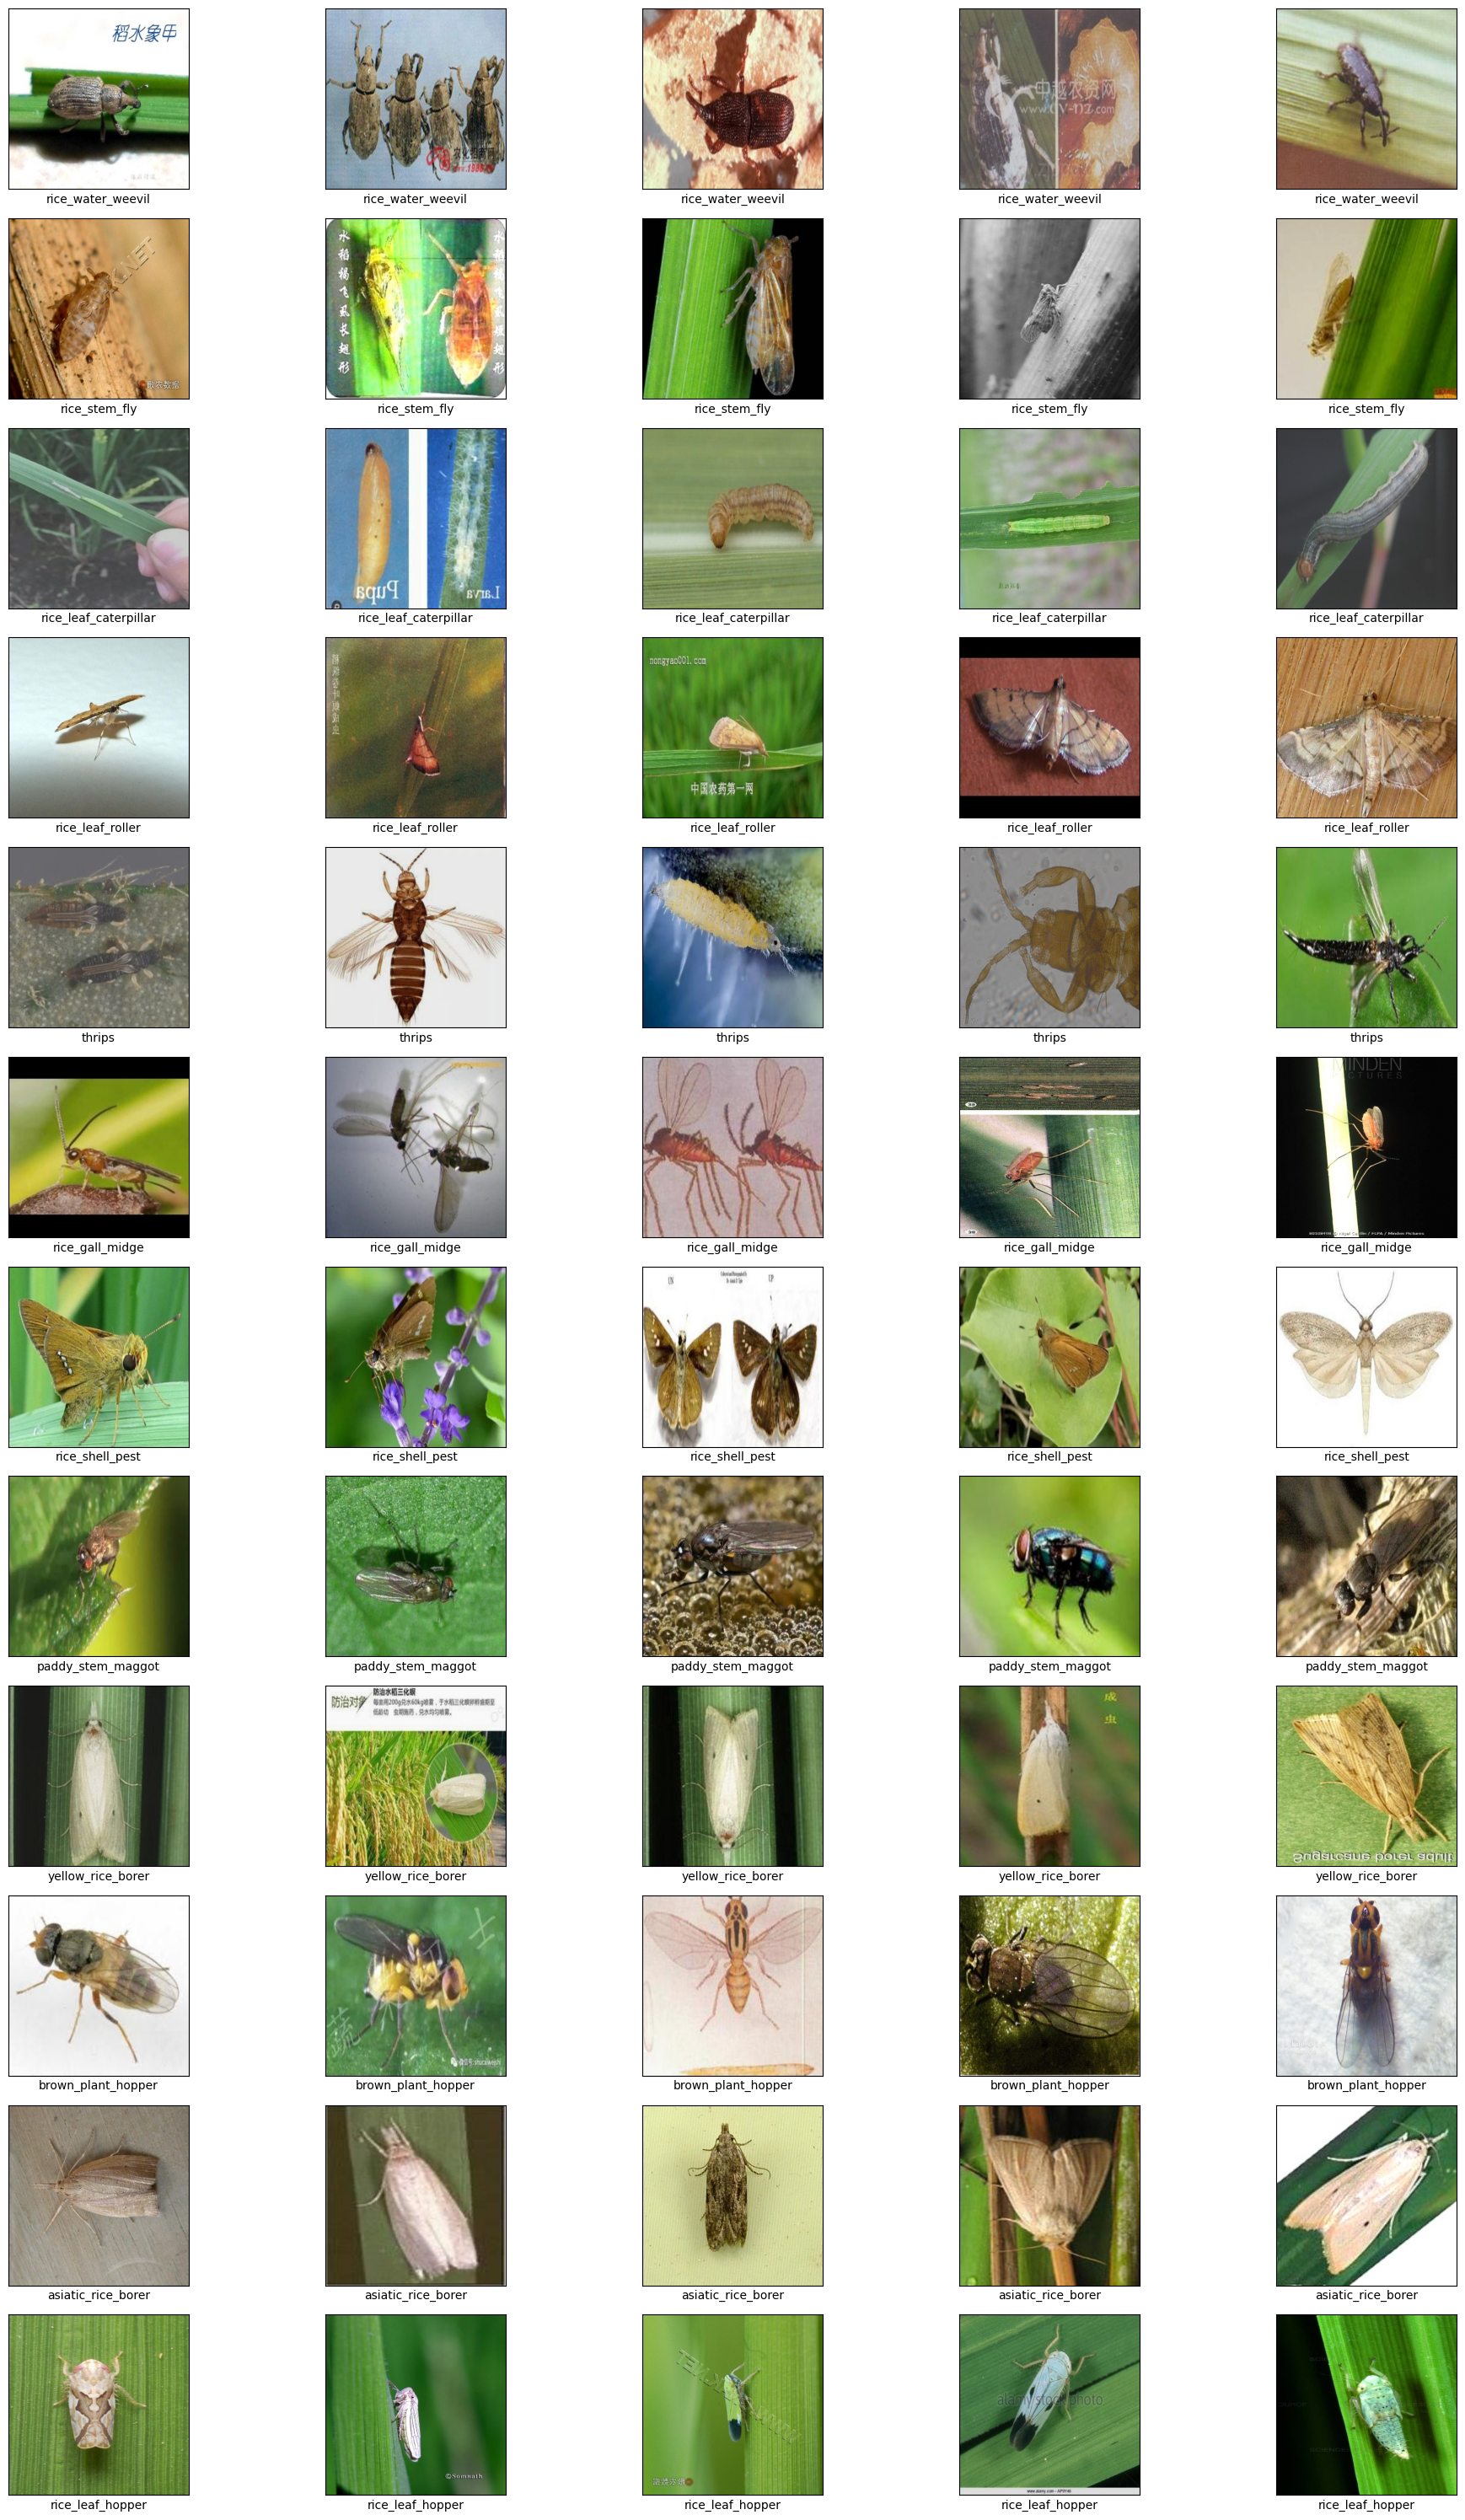

In [ ]:
# Path ke dataset gabungan
path_sub = "/content/rice-pest-detection/dataset"

# Membuat kamus yang menyimpan daftar nama file gambar untuk tiap kelas
rice_pest_images = {}
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        rice_pest_images[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(rice_pest_images), 5, figsize=(20, len(rice_pest_images) * 2.5))

for i, (class_name, images) in enumerate(rice_pest_images.items()):
    sample_images = np.random.choice(images, 5, replace=False)
    for j, image_name in enumerate(sample_images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

## Plot distribusi gambar tiap kelas

<Axes: xlabel='count', ylabel='labels'>

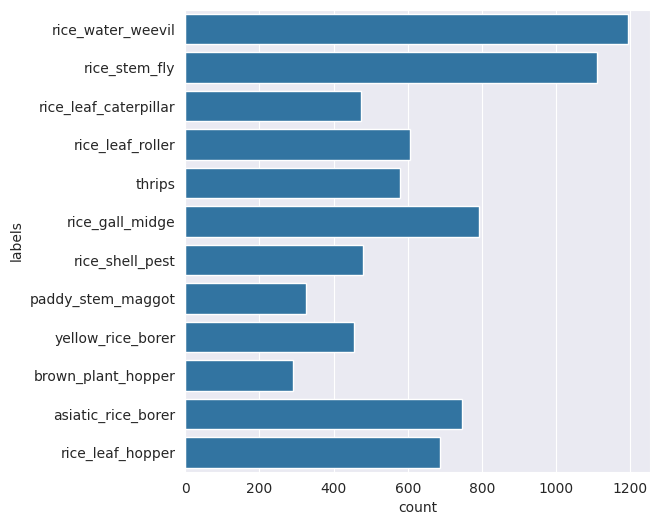

In [ ]:
rice_pest_path = "/content/rice-pest-detection/dataset"

# membuat daftar list untuk menyimpan filename, path, dan label tiap data
file_name = []
labels = []
full_path = []

# membuat daftar yang menyimpan data untuk setiap nama file, jalur file, dan label dalam data
for path, subdirs, files in os.walk(rice_pest_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_train)

# Augmentasi data

In [ ]:
input_dir = '/content/rice-pest-detection/dataset'
target_count = 1200  # target agar seimbang

# Augmentasi generator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    image_list = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(image_list)
    print(f"{class_name}: {current_count} images")

    if current_count >= target_count:
        continue  # skip if sudah cukup

    augment_needed = target_count - current_count
    i = 0

    while i < augment_needed:
        img_name = image_list[i % current_count]
        img_path = os.path.join(class_path, img_name)

        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        for batch in datagen.flow(x, batch_size=1):
            new_filename = f"aug_{i}_{img_name}"
            save_img(os.path.join(class_path, new_filename), batch[0].astype('uint8'))
            i += 1
            if i >= augment_needed:
                break

    print(f"Augmented {class_name} to {target_count} images.")

rice_water_weevil: 1194 images
Augmented rice_water_weevil to 1200 images.
rice_stem_fly: 1110 images
Augmented rice_stem_fly to 1200 images.
rice_leaf_caterpillar: 475 images
Augmented rice_leaf_caterpillar to 1200 images.
rice_leaf_roller: 605 images
Augmented rice_leaf_roller to 1200 images.
thrips: 580 images
Augmented thrips to 1200 images.
rice_gall_midge: 791 images
Augmented rice_gall_midge to 1200 images.
rice_shell_pest: 480 images
Augmented rice_shell_pest to 1200 images.
paddy_stem_maggot: 325 images
Augmented paddy_stem_maggot to 1200 images.
yellow_rice_borer: 455 images
Augmented yellow_rice_borer to 1200 images.
brown_plant_hopper: 290 images
Augmented brown_plant_hopper to 1200 images.
asiatic_rice_borer: 745 images
Augmented asiatic_rice_borer to 1200 images.
rice_leaf_hopper: 686 images
Augmented rice_leaf_hopper to 1200 images.


## Distribusi gambar tiap kelas setelah augmentasi

<Axes: xlabel='count', ylabel='labels'>

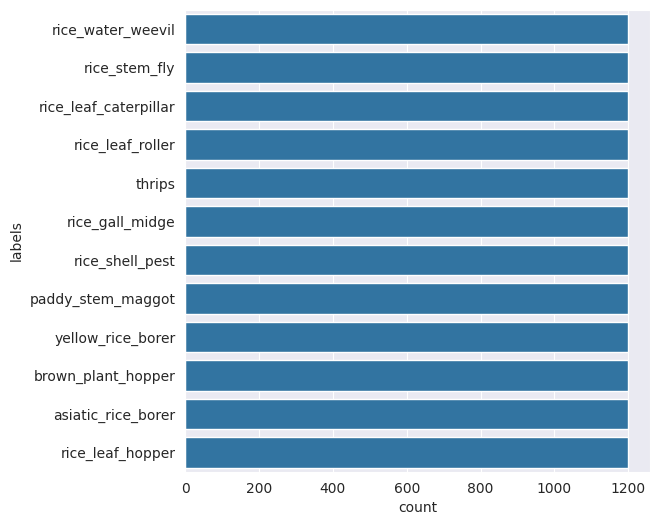

In [ ]:
rice_pest_path = "/content/rice-pest-detection/dataset"

# membuat daftar list untuk menyimpan filename, path, dan label tiap data
file_name = []
labels = []
full_path = []

# membuat daftar yang menyimpan data untuk setiap nama file, jalur file, dan label dalam data
for path, subdirs, files in os.walk(rice_pest_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
sns.countplot(y='labels', data=distribution_train)

# Data splitting: training dan testing

In [ ]:
# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
asiatic_rice_borer       1200
brown_plant_hopper       1200
paddy_stem_maggot        1200
rice_gall_midge          1200
rice_leaf_caterpillar    1200
rice_leaf_hopper         1200
rice_leaf_roller         1200
rice_shell_pest          1200
rice_stem_fly            1200
rice_water_weevil        1200
thrips                   1200
yellow_rice_borer        1200
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# pemisahan variabel data label dan path
X= df['path']
y= df['labels']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 11520
test size 2880


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels               
test   asiatic_rice_borer       269
       brown_plant_hopper       243
       paddy_stem_maggot        271
       rice_gall_midge          256
       rice_leaf_caterpillar    236
       rice_leaf_hopper         231
       rice_leaf_roller         221
       rice_shell_pest          237
       rice_stem_fly            216
       rice_water_weevil        238
       thrips                   237
       yellow_rice_borer        225
train  asiatic_rice_borer       931
       brown_plant_hopper       957
       paddy_stem_maggot        929
       rice_gall_midge          944
       rice_leaf_caterpillar    964
       rice_leaf_hopper         969
       rice_leaf_roller         979
       rice_shell_pest          963
       rice_stem_fly            984
       rice_water_weevil        962
       thrips                   963
       yellow_rice_borer        975
dtype: int64 


                                                    path              labels  \
11381  /co

In [ ]:
datasource_path = "/content/rice-pest-detection/datasett"
dataset_path = "Dataset-Final/"

In [ ]:
from tqdm.notebook import tqdm as tq

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# init folder train dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# list dari semua label/kelas
classes = [
    "rice_leaf_roller",
    "rice_leaf_caterpillar",
    "paddy_stem_maggot",
    "asiatic_rice_borer",
    "yellow_rice_borer",
    "rice_gall_midge",
    "brown_plant_hopper",
    "rice_stem_fly",
    "rice_water_weevil",
    "rice_leaf_hopper",
    "rice_shell_pest",
    "thrips"
]

# looping semua kelas/folde dan jumlah gambar tiap kelas
for class_name in classes:
    train_class_dir = os.path.join(TRAIN_DIR, class_name)
    test_class_dir = os.path.join(TEST_DIR, class_name)

    # cek ketersediaan folder dan mencetak jumlah gambar
    if os.path.exists(train_class_dir) and os.path.exists(test_class_dir):
        print(f"Total number of {class_name} images in training set: ", len(os.listdir(train_class_dir)))
        print(f"Total number of {class_name} images in test set: ", len(os.listdir(test_class_dir)))
    else:
        print(f"Directories for {class_name} not found in training or test set.")

Total number of rice_leaf_roller images in training set:  979
Total number of rice_leaf_roller images in test set:  221
Total number of rice_leaf_caterpillar images in training set:  964
Total number of rice_leaf_caterpillar images in test set:  236
Total number of paddy_stem_maggot images in training set:  929
Total number of paddy_stem_maggot images in test set:  271
Total number of asiatic_rice_borer images in training set:  931
Total number of asiatic_rice_borer images in test set:  269
Total number of yellow_rice_borer images in training set:  975
Total number of yellow_rice_borer images in test set:  225
Total number of rice_gall_midge images in training set:  944
Total number of rice_gall_midge images in test set:  256
Total number of brown_plant_hopper images in training set:  957
Total number of brown_plant_hopper images in test set:  243
Total number of rice_stem_fly images in training set:  984
Total number of rice_stem_fly images in test set:  216
Total number of rice_water

# Image data generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (250, 250)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # rotation_range=20,
    # zoom_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 9223 images belonging to 12 classes.
Found 2297 images belonging to 12 classes.
Found 2880 images belonging to 12 classes.


# Modelling

## CNN Layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense

tf.keras.backend.clear_session()

model_1 = Sequential()

# layer pertama Convolutional, batch normalization, pooling
model_1.add(Conv2D(32, (3, 3), padding='same', input_shape=(250, 250, 3)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout ringan
model_1.add(Dropout(0.15))

# layer kedua Convolutional, batch normalization, pooling layer
model_1.add(Conv2D(64, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

# layer ketiga Convolutional, batch normalization, pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# layer flatten + fully connected
model_1.add(Flatten())
model_1.add(Dense(128))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.3))

# output layer
model_1.add(Dense(12, activation='softmax'))

# compile model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,841,356 (60.43 MB)

 Trainable params: 15,840,652 (60.43 MB)

 Non-trainable params: 704 (2.75 KB)

## Fitting model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# fit model
%time
history_1 = model_1.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[lr_reduction]
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Epoch 1/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - accuracy: 0.6770 - loss: 1.1269 - val_accuracy: 0.1441 - val_loss: 2.7867 - learning_rate: 5.0000e-04
Epoch 2/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.7842 - loss: 0.7206 - val_accuracy: 0.3339 - val_loss: 2.2633 - learning_rate: 5.0000e-04
Epoch 3/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.8265 - loss: 0.5698 - val_accuracy: 0.4728 - val_loss: 1.7749 - learning_rate: 5.0000e-04
Epoch 4/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.8713 - loss: 0.4474 - val_accuracy: 0.5564 - val_loss: 1.4494 - learning_rate: 5.0000e-04
Epoch 5/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.8983 - loss: 0.3492 - val_accuracy: 0.5747 - val_loss: 1.4078 - learning_rate: 5.0000e-04
Epoch 6/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.9138 - loss: 0.2925 - val_accuracy: 0.5581 - val_loss: 1.5127 - learning

# Evaluasi

Akurasi Terakhir Validation: 94.51%
Loss Terakhir Validation: 0.3674


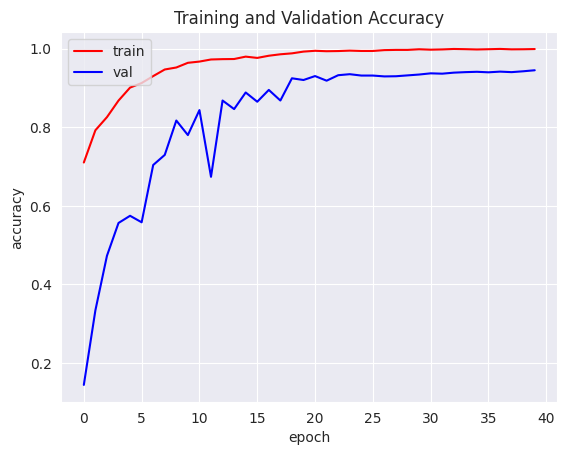

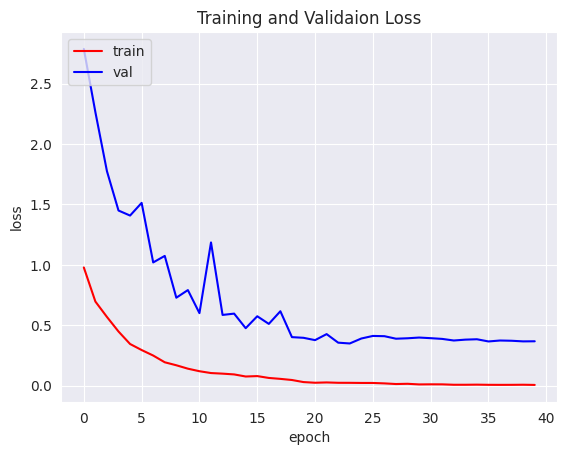

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

print(f"Akurasi Terakhir Validation: {val_acc[-1]*100:.2f}%")
print(f"Loss Terakhir Validation: {val_loss[-1]:.4f}")

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

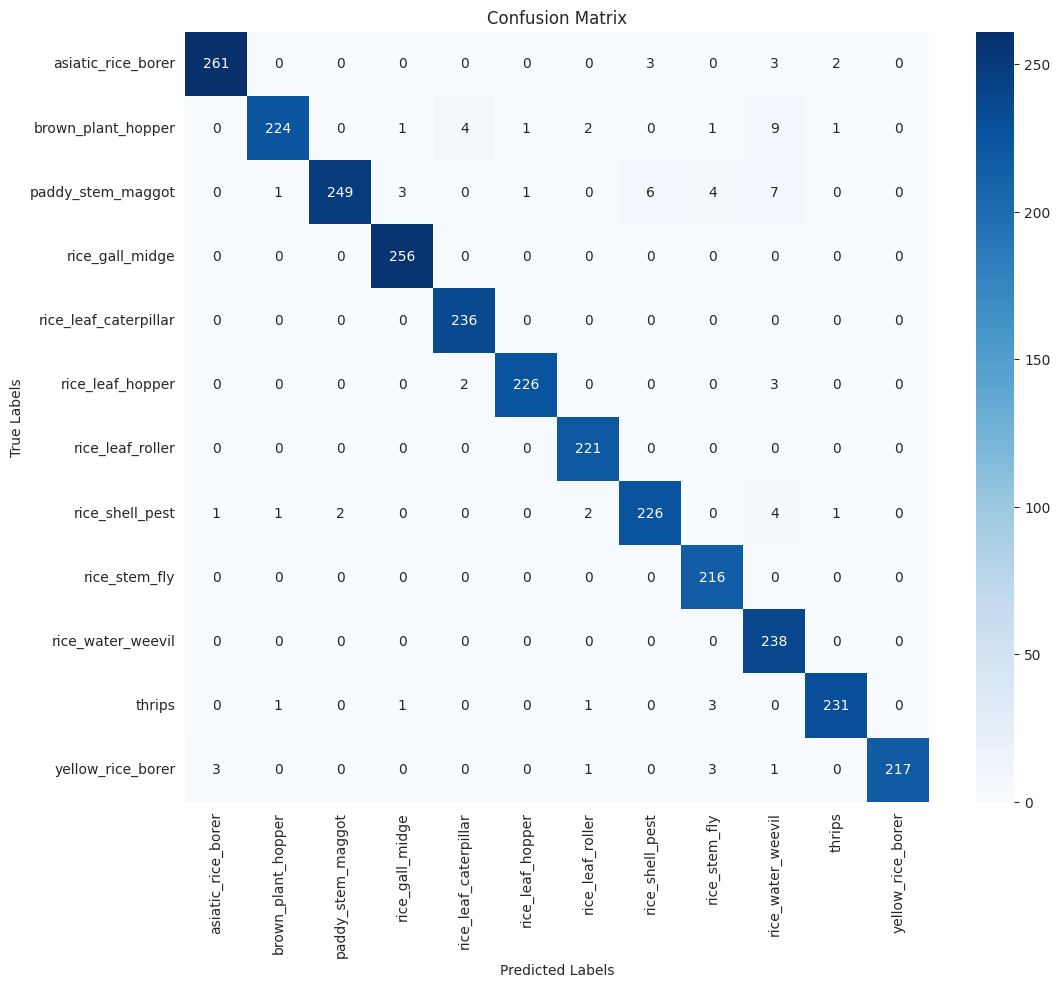


Classification Report:

                       precision    recall  f1-score   support

   asiatic_rice_borer     0.9849    0.9703    0.9775       269
   brown_plant_hopper     0.9868    0.9218    0.9532       243
    paddy_stem_maggot     0.9920    0.9188    0.9540       271
      rice_gall_midge     0.9808    1.0000    0.9903       256
rice_leaf_caterpillar     0.9752    1.0000    0.9874       236
     rice_leaf_hopper     0.9912    0.9784    0.9847       231
     rice_leaf_roller     0.9736    1.0000    0.9866       221
      rice_shell_pest     0.9617    0.9536    0.9576       237
        rice_stem_fly     0.9515    1.0000    0.9752       216
    rice_water_weevil     0.8981    1.0000    0.9463       238
               thrips     0.9830    0.9747    0.9788       237
    yellow_rice_borer     1.0000    0.9644    0.9819       225

             accuracy                         0.9726      2880
            macro avg     0.9732    0.9735    0.9728      2880
         weighted avg     0.

In [ ]:
# Reset generator
test_generator.reset()

# Lakukan prediksi
preds = model_1.predict(test_generator, verbose=0)

# Ambil indeks kelas dengan probabilitas tertinggi (multi-class)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes

# Ambil nama kelas
class_labels = list(test_generator.class_indices.keys())

# Buat Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Visualisasi Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Tampilkan Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Inferensi

In [ ]:
test_dir = '/content/Dataset-Final/test'

# Ambil mapping class dari train_generator
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# looping ke setiap folder
for label_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, label_folder)

    if not os.path.isdir(class_path):
        continue

    # ambil 1 file gambar pertama di tiap folder
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        continue

    img_path = os.path.join(class_path, image_files[0])

    # load dan preprocess gambar yang telah diambil
    img = image.load_img(img_path, target_size=(250, 250))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # prediksi dari gambar yang telah di proses
    pred = model_1.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    print(f"Folder: {label_folder}")
    print(f"Image: {image_files[0]}")
    print(f"Predicted: {predicted_label}")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Folder: rice_water_weevil
Image: 8 (233).jpg
Predicted: rice_water_weevil
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Folder: rice_stem_fly
Image: 7 (711).jpg
Predicted: rice_stem_fly
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Folder: rice_leaf_caterpillar
Image: 1 (259).jpg
Predicted: rice_leaf_caterpillar
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Folder: rice_leaf_roller
Image: 0 (370).jpg
Predicted: rice_leaf_roller
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Folder: thrips
Image: 11 (149).jpg
Predicted: thrips
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Folder: rice_gall_midge
Image: 5 (366).jpg
Predicted: rice_gall_midge
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Folder: rice_shell_pest
Image: 10 (466).jpg
Predicted: rice_shell_pest
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

# Save Model

In [ ]:
model_1.save('rice_pest_model.h5')